# Tutorial 2
Travaille réalisé par Gaël Crespi, Wiame Gamgami et Kevin Lion

## Importing librairies

In [1]:
# essential libraries
import json
import random
from urllib.request import urlopen
from urllib.request import urlopen
import os
import IPython.display
import librosa.display
import sys
import glob

# storing and analysis
import numpy as np
import pandas as pd
from scipy.io import arff
import seaborn as sns
import misc_utils as utils

# ML 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import IsolationForest

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

# converter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()   

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# Librosa
import librosa

# <center>Clustering Exercice 1</center>

## Reading the Dataset 

In [2]:
data = pd.read_csv('CollegeScorecard.csv')

## Understanding the data 

In [3]:
data.shape

(7804, 1725)

In [4]:
data.head()

UNITID    OPEID  opeid6                               INSTNM        CITY  \
0  100654   100200    1002             Alabama A & M University      Normal   
1  100663   105200    1052  University of Alabama at Birmingham  Birmingham   
2  100690  2503400   25034                   Amridge University  Montgomery   
3  100706   105500    1055  University of Alabama in Huntsville  Huntsville   
4  100724   100500    1005             Alabama State University  Montgomery   

  STABBR         ZIP                                       AccredAgency  \
0     AL       35762  Southern Association of Colleges and Schools C...   
1     AL  35294-0110  Southern Association of Colleges and Schools C...   
2     AL  36117-3553  Southern Association of Colleges and Schools C...   
3     AL       35899  Southern Association of Colleges and Schools C...   
4     AL  36104-0271  Southern Association of Colleges and Schools C...   

                          INSTURL  \
0                   www.aamu.edu/   
1                     www.uab.edu   
2       www.amridgeuniversity.edu   
3                     www.uah.edu   
4  www.alasu.edu/email/index.aspx   

                                              NPCURL  ...  \
0     galileo.aamu.edu/netpricecalculator/npcalc.htm  ...   
1    www.collegeportraits.org/AL/UAB/estimator/agree  ...   
2  tcc.noellevitz.com/(S(miwoihs5stz5cpyifh4nczu0...  ...   
3                                    finaid.uah.edu/  ...   
4  www.alasu.edu/cost-aid/forms/calculator/index....  ...   

   COMPL_RPY_3YR_RT_SUPP  NONCOM_RPY_3YR_RT_SUPP  DEP_RPY_3YR_RT_SUPP  \
0            0.578873239             0.373790022          0.442857143   
1            0.847800926             0.678748759          0.767798013   
2            0.807692308              0.61328125    PrivacySuppressed   
3            0.892045455             0.689788054          0.800347222   
4            0.482490272             0.315996848           0.32410212   

   IND_RPY_3YR_RT_SUPP  PELL_RPY_3YR_RT_SUPP  NOPELL_RPY_3YR_RT_SUPP  \
0           0.45890411           0.443586698             0.452513966   
1          0.739164697           0.732297853             0.795454545   
2          0.641114983           0.600877193                   0.775   
3           0.75564409           0.738341969             0.851405622   
4          0.350993377           0.320016821             0.380829016   

   FEMALE_RPY_3YR_RT_SUPP  MALE_RPY_3YR_RT_SUPP  FIRSTGEN_RPY_3YR_RT_SUPP  \
0             0.484818805                 0.406               0.423580786   
1             0.760521886           0.755344418               0.751552795   
2             0.610465116           0.686567164               0.632653061   
3             0.768378651            0.79844098               0.778156997   
4             0.364423718           0.286530612               0.315737052   

   NOTFIRSTGEN_RPY_3YR_RT_SUPP  
0                   0.44245283  
1                  0.765074771  
2                         0.65  
3                  0.791666667  
4                  0.334633385  

[5 rows x 1725 columns]

## Pre pocessing 

### Deleting duplicate columns

In [5]:
data = data.drop_duplicates()

### Dropping columns with more than 50 % data missing

In [6]:
data = data.replace(to_replace="PrivacySuppressed", value=np.nan)
x = data.isnull().sum()[data.isnull().sum()>=2300]
data.drop(columns=x.index,inplace= True)
print('Number of droped columns : ' ,x.shape[0])
print('New dataset shape :', data.shape)

Number of droped columns :  1375
New dataset shape : (7804, 350)


### To apply PCA we need to remove qualitative columns

In [7]:
binary_column = data.nunique()[data.nunique()==2]
data.drop(columns = binary_column.index, inplace = True)
CIP = data.nunique()[data.nunique()==3]
data.drop(columns = CIP.index, inplace = True)

In [8]:
data.nunique()[data.nunique()<=20]

PREDDEG     5
HIGHDEG     5
region     10
LOCALE     12
PCIP29     12
dtype: int64

In [9]:
data.drop(columns= ['PREDDEG','HIGHDEG','UNITID', 'OPEID', 'opeid6', 'INSTNM', 'CITY','STABBR', 
                    'ZIP', 'AccredAgency', 'INSTURL', 'NPCURL','st_fips','LATITUDE', 'LONGITUDE']
                    , inplace=True)

In [10]:
data.shape

(7804, 129)

### Some quantitative columns has missing values, we have to treat it 

In [11]:
data = data.fillna(data.median())

In [12]:
null_val = data.isnull().sum()[data.isnull().sum()>0]
nan_val = data.isna().sum()[data.isna().sum()>0]
print(nan_val, ' // ', null_val)

Series([], dtype: int64)  //  Series([], dtype: int64)


## Correlation matrix

<AxesSubplot:>

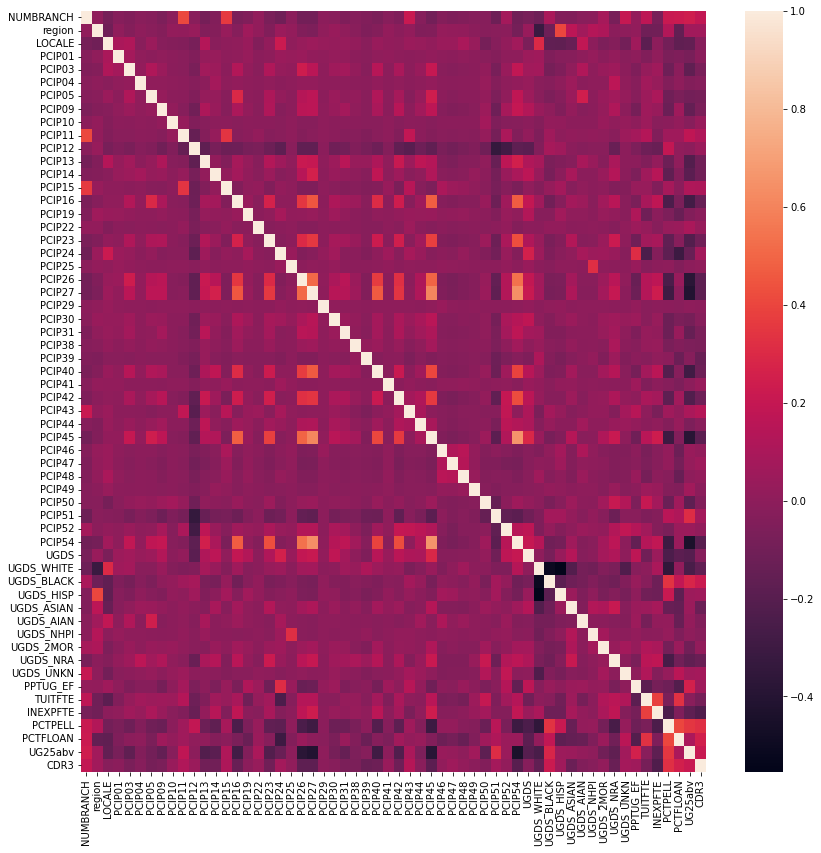

In [13]:
plt.figure(figsize=(14,14))
CorrMatrix = data.corr()
sns.heatmap(CorrMatrix)

## PCA

In [14]:
X=data.values
pca = PCA(n_components= 129)
pca_fit=pca.fit(X)
reduced_X = pca_fit.transform(X)
var_explained= pca.explained_variance_ratio_
var_explained_cumulative=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
plt.plot( range(1,130), var_explained_cumulative )
plt.axhline(y=97,color='gray',linestyle='--')
plt.axvline(x=4,color='gray',linestyle='--')
plt.xlabel('Number of components')
plt.ylabel('% Variance explained')
plt.xlim(0,20);

4 components is the optimal value for the PCA

In [15]:
pca = PCA(n_components=4)
pca_fit = pca.fit(X)
reduced_X = pca_fit.transform(X)
df2= pd.DataFrame(reduced_X, columns=['PC1','PC2','PC3','PC4'])

In [16]:
cols = list()
for i in range(1, 5):
    cols.append("PC" + str(i))
pca = pd.DataFrame(reduced_X, columns=cols)

In [17]:
fig, axes = plt.subplots(figsize=(15, 15))
pca.hist(bins=100, xlabelsize=0.5, ylabelsize=0.5, ax=axes)
plt.show()

In [18]:
Components = pca_fit.components_[:6]
Components = pd.DataFrame(Components, index=cols, columns=data.columns).T
print(Components.sort_values("PC1", axis=0, ascending=False).iloc[:5, 0])
print("************************")
print(Components.sort_values("PC2", axis=0, ascending=False).iloc[:5, 1])
print("************************")
print(Components.sort_values("PC3", axis=0, ascending=False).iloc[:5, 2])
print("************************")
print(Components.sort_values("PC4", axis=0, ascending=False).iloc[:5, 3])
print("************************")

RPY_3YR_N         0.352249
DEBT_N            0.303691
CUML_DEBT_N       0.303691
IND_DEBT_N        0.274606
PELL_RPY_3YR_N    0.259723
Name: PC1, dtype: float64
************************
DEP_INC_AVG           0.751006
CUML_DEBT_P90         0.276123
CUML_DEBT_P75         0.237800
GRAD_DEBT_MDN         0.212914
GRAD_DEBT_MDN_SUPP    0.208786
Name: PC2, dtype: float64
************************
APPL_SCH_N       0.318808
PAR_ED_N         0.249031
CUML_DEBT_P90    0.218742
IND_INC_N        0.214794
GRAD_DEBT_MDN    0.187580
Name: PC3, dtype: float64
************************
CUML_DEBT_P90         0.400571
CUML_DEBT_P75         0.271448
GRAD_DEBT_MDN         0.260810
GRAD_DEBT_MDN_SUPP    0.257745
RPY_3YR_N             0.159060
Name: PC4, dtype: float64
************************


## Number of clusters

In [19]:
PredictScaler=StandardScaler()
x= df2.values
PredictScaler.fit(x)
x_scaled= PredictScaler.transform(x)
df3= pd.DataFrame(x_scaled)
df3.columns=['PC1','PC2','PC3','PC4']
val=df3.values
ScoreValue = []
for i in range(2, 15):
    km = KMeans(n_clusters=i, init='random', n_init=10, max_iter=300,tol=1e-04,random_state=0)
    km.fit(val)
    score=silhouette_score(val, km.labels_)
    ScoreValue.append(score)
    
plt.plot(range(2, 15), ScoreValue, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silouhette Score')
plt.tight_layout()
plt.show()

## Clustering

In [20]:
clf_km = KMeans(n_clusters= 5, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=0)
predict = clf_km.fit_predict(val)
df3['PredictedClusterID']=predict

In [21]:
df3['PredictedClusterID'].value_counts()

0    4227
1    1915
4    1429
2     162
3      71
Name: PredictedClusterID, dtype: int64

In [22]:
sns.pairplot(df3,hue='PredictedClusterID')

In [23]:
plt.figure(figsize=(14,14))
CorrMatrix = df3.corr()
px.bar(CorrMatrix[:-1], 'PredictedClusterID',color='PredictedClusterID')

<Figure size 1008x1008 with 0 Axes>

# Conclusion

Explications Clusters :
- 0 : LOW PC2, PC3, PC4
- 1 : HIGH PC3, PC4
- 2 : Négligeable ?
- 3 : Négligeable ?
- 4 : HIGH PC2, LOW PC3, PC4

**Notre démarche a été la suivante :**
- Nous avons nettoyé notre dataset car en effet il y avait beaucoup de colonnes (qui sont donc des features), certaines sont utiles d'autres non ou pouvant etre négligées.
- Après nettoyage, nous avions encore un nombre élevé de features. Nous avons donc appliqué une analyse à composantes principales pour réduire cette quantité de features en gardant les informations principales du dataset (Voir partie PCA, 97% de la variance est conservé avec 4 composantes principales) nous avons aussi affiché les principales features dont sont composés les CP.
- Le dataset étant nettoyé et condensé, nous avons appliqué un model de machine learning d'apprentissage non supervisé, le Kmeans. Le Kmeans est un algorythme itératif qui va s'éforcer de créer des groupes en calculant la distance (euclidienne dans notre cas) de chaque individu par rapport au centroide de chaque groupe puis il va l'affecté au groupe ayant le centroîde le plus proche de cette individu.
- Grace à la fonction silouhette score, nous pouvons identifier le nombre de clusters optimal (Voir partie Clustering, 3 clusters)
- Nous avons prédis à quel cluster appartenait chaque individu
- Enfin, l'objectif était de comprendre ce qui différenciait les clusters, nous voyons que la CP 2 est la plus corrélée avec la prédiction de clusters, cette cp représente majoritairement les features suivantes DEP_INC_AVG CUML_DEBT_P90    CUML_DEBT_P75 GRAD_DEBT_MDN GRAD_DEBT_MDN_SUPP

# <center>Anomaly detection Exercice 2</center>

In [24]:
plt.style.use("Solarize_Light2")
prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]

In [25]:
DATA_PATH = "../pump/"
IMAGE_PATH = "./img"

os.makedirs(DATA_PATH, exist_ok=True)
os.makedirs(IMAGE_PATH, exist_ok=True)

In [26]:
n_fft = 2048
normal_path = "pump/id_00/normal/"
list_fan_normal = sorted(os.listdir(normal_path))
#list_fan_normal.remove('.ipynb_checkpoints')
abnormal_path = "pump/id_00/abnormal/"
list_fan_abnormal = sorted(os.listdir(abnormal_path))
#list_fan_abnormal.remove('.ipynb_checkpoints')

train_data=[]
test_data=[]
for files in list_fan_normal:
    data=librosa.load("pump/id_00/normal/"+files)[0]
    train_data.append(data)
for files in list_fan_abnormal:
    data=librosa.load("pump/id_00/abnormal/"+files)[0]
    test_data.append(data)

In [27]:
normal_signal, _ = librosa.load("pump/id_00/normal/00000000.wav")
abnormal_signal, sr = librosa.load("pump/id_00/abnormal/00000000.wav")

print( f"The signals have a {normal_signal.shape} shape. At {sr} Hz, these are {normal_signal.shape[0] / sr:.0f}s signals.")

The signals have a (220500,) shape. At 22050 Hz, these are 10s signals.


In [28]:
IPython.display.Audio(normal_signal, rate=_)

In [29]:
IPython.display.Audio(abnormal_signal, rate=sr)

In [30]:
fig = plt.figure(figsize=(38, 8))

plt.subplot(1, 3, 1)
librosa.display.waveplot(normal_signal,sr=sr,alpha=0.5,color=colors[1],linewidth=0.5,label="Machine #id_00 - Normal Signal")
plt.title("Normal Signal")

plt.subplot(1, 3, 2)
librosa.display.waveplot(abnormal_signal,sr=sr,alpha=0.6,color=colors[5],linewidth=0.5,label="Machine #id_00 - Abnormal Signal")
plt.title("Abnormal Signal")

plt.subplot(1, 3, 3)
librosa.display.waveplot(abnormal_signal,sr=sr,alpha=0.6,color=colors[5],linewidth=0.5,label="Abnormal Signal")
librosa.display.waveplot(normal_signal,sr=sr,alpha=0.5,color=colors[1],linewidth=0.5,label="Normal Signal")
plt.title("Both Signals")

fig.suptitle("Machine #id_00 - 2D Representation of the Wave Forms", fontsize=16)
plt.legend()
plt.show()
fig.savefig(os.path.join(IMAGE_PATH, "wave_forms.svg"), format="svg")

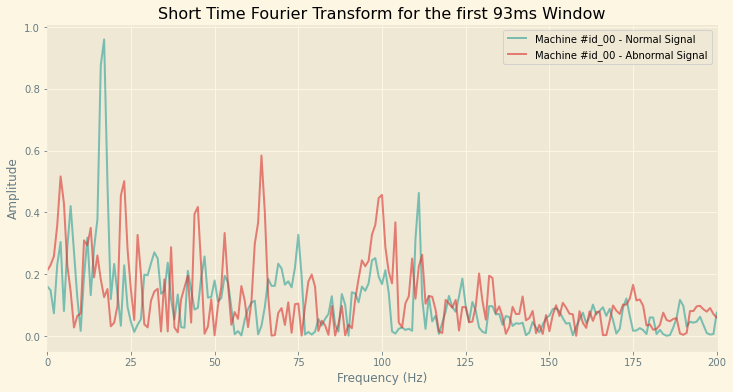

In [31]:
n_fft = 2048
normal_stft = np.abs(librosa.stft(normal_signal[:n_fft], n_fft=n_fft, hop_length=n_fft + 1))
abnormal_stft = np.abs(librosa.stft(abnormal_signal[:n_fft], n_fft=n_fft, hop_length=n_fft + 1))

fig = plt.figure(figsize=(12, 6))
plt.plot(normal_stft, color=colors[1], alpha=0.6, label="Machine #id_00 - Normal Signal")
plt.plot(abnormal_stft, color=colors[5], alpha=0.6, label="Machine #id_00 - Abnormal Signal")
plt.title( f"Short Time Fourier Transform for the first {n_fft / sr * 1000:.0f}ms Window")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.legend()
plt.xlim(0, 200)
plt.show()
fig.savefig(os.path.join(IMAGE_PATH, "stft.svg"), format="svg")

In [32]:
hop_length = 512
normal_stft = np.abs(librosa.stft(normal_signal, n_fft=n_fft, hop_length=hop_length))
normal_spectrogram = librosa.amplitude_to_db(normal_stft, ref=np.max)
abnormal_stft = np.abs(librosa.stft(abnormal_signal, n_fft=n_fft, hop_length=hop_length))
abnormal_spectrogram = librosa.amplitude_to_db(abnormal_stft, ref=np.max)

fig = plt.figure(figsize=(24, 6))

plt.subplot(1, 2, 1)
librosa.display.specshow(normal_spectrogram, sr=sr, x_axis="time", y_axis="mel", cmap="viridis")
plt.title("Machine #id_00 - Normal Signal")
plt.colorbar(format="%+2.f dB")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")

plt.subplot(1, 2, 2)
librosa.display.specshow( abnormal_spectrogram, sr=sr, x_axis="time", y_axis="mel", cmap="viridis")
plt.title("Machine #id_00 - Abnormal Signal")
plt.ylabel("Frequency (Hz)")
plt.colorbar(format="%+2.f dB")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")

plt.show()
fig.savefig(os.path.join(IMAGE_PATH, "spectrograms.svg"), format="svg")

print(f"The spectrograms have a {normal_spectrogram.shape} shape.")

The spectrograms have a (1025, 431) shape.


**ID 00 PUMP ANOMALY PREDICTION**

In [33]:
normal_files, abnormal_files = train_data,test_data
normal_labels = np.zeros(len(normal_files))
abnormal_labels = np.ones(len(abnormal_files))

train_files, test_files, train_labels, test_labels = train_test_split(normal_files, normal_labels, train_size=0.8, random_state=42, shuffle=True)

test_files = np.concatenate((test_files, abnormal_files), axis=0)
test_labels = np.concatenate((test_labels, abnormal_labels), axis=0)

test_indices = np.arange(len(test_files))
np.random.shuffle(test_indices)

test_files = test_files[test_indices]
test_labels = test_labels[test_indices]

print(f"Train set has {train_labels.shape[0]} signals including abnormal {train_labels.sum():.0f} signals, \
but test set has {test_labels.shape[0]} signals including abnormal {test_labels.sum():.0f} signals.")

Train set has 804 signals including abnormal 0 signals, but test set has 345 signals including abnormal 143 signals.


In [34]:
clf_km = KMeans(n_clusters= 2, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=0)
clf_km = clf_km.fit(train_files)
y_pred_train = clf_km.fit_predict(train_files)
y_pred_test = clf_km.fit_predict(test_files)
confusion_matrix(test_labels,y_pred_test)

array([[202,   0],
       [142,   1]], dtype=int64)

In [35]:
clf = IsolationForest(max_samples=100, random_state=0)
clf.fit(train_files)
y_pred_train = clf.predict(train_files)
y_pred_test = clf.predict(test_files)
y_pred_test[y_pred_test == 1] = 0
y_pred_test[y_pred_test == -1] = 1
confusion_matrix(test_labels,y_pred_test)

array([[202,   0],
       [ 51,  92]], dtype=int64)

**ID 00 VALVE ANOMALY DETECTION**

In [36]:
normal_signal, _ = librosa.load("valve/id_00/normal/00000000.wav")
abnormal_signal, sr = librosa.load("valve/id_00/abnormal/00000000.wav")

In [37]:
fig = plt.figure(figsize=(38, 8))

plt.subplot(1, 3, 1)
librosa.display.waveplot(normal_signal,sr=sr,alpha=0.5,color=colors[1],linewidth=0.5,label="Machine #id_00 - Normal Signal")
plt.title("Normal Signal")

plt.subplot(1, 3, 2)
librosa.display.waveplot(abnormal_signal,sr=sr,alpha=0.6,color=colors[5],linewidth=0.5,label="Machine #id_00 - Abnormal Signal")
plt.title("Abnormal Signal")

plt.subplot(1, 3, 3)
librosa.display.waveplot(abnormal_signal,sr=sr,alpha=0.6,color=colors[5],linewidth=0.5,label="Abnormal Signal")
librosa.display.waveplot(normal_signal,sr=sr,alpha=0.5,color=colors[1],linewidth=0.5,label="Normal Signal")
plt.title("Both Signals")

fig.suptitle("Machine #id_00 - 2D Representation of the Wave Forms", fontsize=16)
plt.legend()
plt.show()
fig.savefig(os.path.join(IMAGE_PATH, "wave_forms.svg"), format="svg")

In [38]:
normal_path = "valve/id_00/normal/"
list_fan_normal = sorted(os.listdir(normal_path))
#list_fan_normal.remove('.ipynb_checkpoints')
abnormal_path = "valve/id_00/abnormal/"
list_fan_abnormal = sorted(os.listdir(abnormal_path))
#list_fan_abnormal.remove('.ipynb_checkpoints')

train_data=[]
test_data=[]
for files in list_fan_normal:
    data=librosa.load("valve/id_00/normal/"+files)[0]
    train_data.append(data)
for files in list_fan_abnormal:
    data=librosa.load("valve/id_00/abnormal/"+files)[0]
    test_data.append(data)

In [39]:
normal_files, abnormal_files = train_data,test_data
normal_labels = np.zeros(len(normal_files))
abnormal_labels = np.ones(len(abnormal_files))

train_files, test_files, train_labels, test_labels = train_test_split(normal_files, normal_labels, train_size=0.8, random_state=42, shuffle=True)

test_files = np.concatenate((test_files, abnormal_files), axis=0)
test_labels = np.concatenate((test_labels, abnormal_labels), axis=0)

test_indices = np.arange(len(test_files))
np.random.shuffle(test_indices)

test_files = test_files[test_indices]
test_labels = test_labels[test_indices]

print(f"Train set has {train_labels.shape[0]} signals including abnormal {train_labels.sum():.0f} signals, \
but test set has {test_labels.shape[0]} signals including abnormal {test_labels.sum():.0f} signals.")

Train set has 792 signals including abnormal 0 signals, but test set has 318 signals including abnormal 119 signals.


In [40]:
clf_km = KMeans(n_clusters= 2, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=0)
clf_km = clf_km.fit(train_files)

In [41]:
y_pred_train = clf_km.fit_predict(train_files)
y_pred_test = clf_km.fit_predict(test_files)
confusion_matrix(test_labels,y_pred_test)

array([[192,   7],
       [113,   6]], dtype=int64)

In [42]:
clf = IsolationForest(max_samples=100, random_state=0)
clf.fit(train_files)
y_pred_train = clf.predict(train_files)
y_pred_test = clf.predict(test_files)
y_pred_test[y_pred_test == 1] = 0
y_pred_test[y_pred_test == -1] = 1
confusion_matrix(test_labels,y_pred_test)

array([[199,   0],
       [119,   0]], dtype=int64)

## Results

- **Pour la machine pump** : Les résultats avec le Kmeans sont mauvais, en effet l'algorithme n'arrive pas à différencier un signal anormal d'un signal normal, tous les signaux anormaux sont prédits normaux. Pour l'Isolation Forest, le résultat est plus concluant, on obtient 80 % d'accuracy et on a du coup un algorithme capable de détecter des anomalies.
- **Pour la machine valve** : Les résultats avec le Kmeans sont aussi mauvais, en effet l'algorithme n'arrive pas à différencier un signal anormal d'un signal normal, tous les signaux anormaux sont prédits normaux. Pour l'Isolation Forest, le résultat n'est plus concluant, l'algorithme n'arrive pas à différencier un signal anormal d'un signal normal. Cela peut s'expliquer car les anomalies sont beaucoup moins importantes sur cette machine que sur la précedente.

On peut donc conclure qu'il est important de se rendre compte que tous les algorithmes ne sont pas applicables à tous les problèmes de détection d'anomalies. Il serait intéressant de résoudre cette détection d'anomalie à l'aide de réseaux de neurones et de comparer les résultats obtenus.

----------------------------------------------------------------------------